# Image Classification

## Importing Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import PIL

from sklearn.model_selection import train_test_split 

print(tf.__version__)

2.3.0


## Create Dataset

In [3]:
print('Number of available datasets:', len(tfds.list_builders()))
# tfds.list_builders()

Number of available datasets: 195


In [4]:
dataset_url = "https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&export=download"
data_dir = tf.keras.utils.get_file('101_ObjectCategories', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [5]:
print(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print('Total number of images:', image_count)

C:\Users\10699\.keras\datasets\101_ObjectCategories
Total number of images: 9144


In [6]:
classes = os.listdir(data_dir)
class_num = len(classes)
print('Number of classes:', class_num)
print(classes[:10], '\n...\n', classes[-9:len(classes)])

Number of classes: 102
['accordion', 'airplanes', 'anchor', 'ant', 'BACKGROUND_Google', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai'] 
...
 ['trilobite', 'umbrella', 'watch', 'water_lilly', 'wheelchair', 'wild_cat', 'windsor_chair', 'wrench', 'yin_yang']


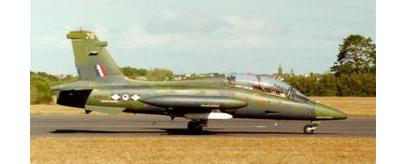

In [7]:
airplanes = list(data_dir.glob('airplanes/*'))
PIL.Image.open(str(airplanes[0]))

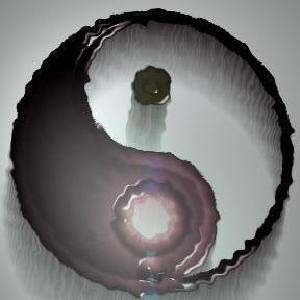

In [8]:
yinyang = list(data_dir.glob('yin_yang/*'))
PIL.Image.open(str(yinyang[5]))

## Data Preprocessing

In [9]:
batch_size = 32
image_width = 128
image_height = 128

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 1,
    image_size = (image_width, image_height),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 1,
    image_size = (image_width, image_height),
    batch_size = batch_size
)

val_size = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.skip(val_size// 2)
val_ds = val_ds.take(val_size//2)

Found 9144 files belonging to 102 classes.
Using 7316 files for training.
Found 9144 files belonging to 102 classes.
Using 1828 files for validation.


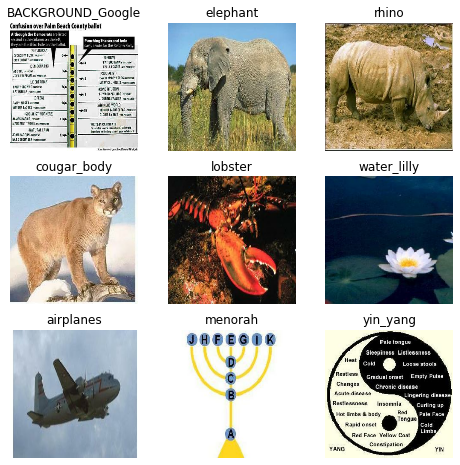

In [11]:
class_names = train_ds.class_names

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Create Model

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', 
                                                          input_shape = (image_width, image_height, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [14]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (image_width, image_height, 3)),
    tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(strides = 2),
    tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(strides = 2),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(strides = 2),
    tf.keras.layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(strides = 2),
    tf.keras.layers.Conv2D(256, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(strides = 2),
    tf.keras.layers.Conv2D(512, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(class_num)
])

In [15]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)       

## Training

In [16]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
229/229 [==============================] - 150s 653ms/step - loss: 4.3986 - accuracy: 0.0939 - val_loss: 3.8371 - val_accuracy: 0.1853
Epoch 2/10
229/229 [==============================] - 149s 652ms/step - loss: 3.5943 - accuracy: 0.2436 - val_loss: 3.1480 - val_accuracy: 0.3373
Epoch 3/10
229/229 [==============================] - 160s 699ms/step - loss: 3.1943 - accuracy: 0.3186 - val_loss: 2.8555 - val_accuracy: 0.3944
Epoch 4/10
229/229 [==============================] - 163s 711ms/step - loss: 2.9077 - accuracy: 0.3695 - val_loss: 2.6490 - val_accuracy: 0.4170
Epoch 5/10
229/229 [==============================] - 163s 712ms/step - loss: 2.6706 - accuracy: 0.4064 - val_loss: 2.4788 - val_accuracy: 0.4526
Epoch 6/10
229/229 [==============================] - 151s 660ms/step - loss: 2.4677 - accuracy: 0.4378 - val_loss: 2.3624 - val_accuracy: 0.4817
Epoch 7/10
229/229 [==============================] - 155s 676ms/step - loss: 2.3035 - accuracy: 0.4751 - val_loss: 2.2686 -

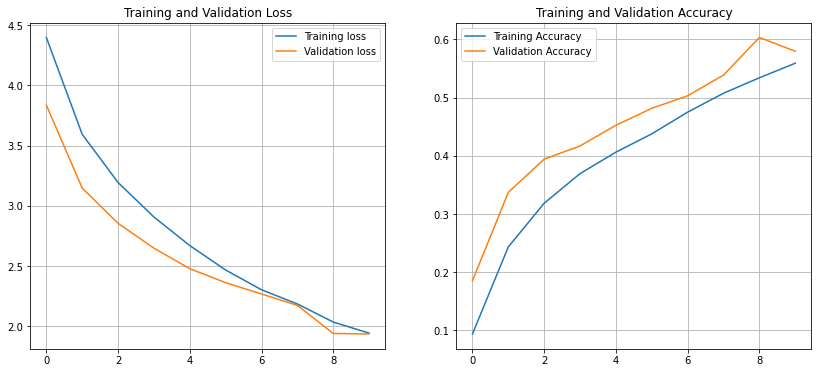

In [17]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, loss, label = 'Training loss')
    plt.plot(epochs_range, val_loss, label = 'Validation loss')
    plt.legend()
    plt.grid()
    plt.title('Training and Validation Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs_range, acc, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.title('Training and Validation Accuracy')

    plt.show()
    
plot_result(history)

In [18]:
model.evaluate(test_ds)

29/29 [==============================] - 5s 162ms/step - loss: 2.0427 - accuracy: 0.5778


[2.04266095161438, 0.5777778029441833]

## Transfer Learing
#### To begin, using the MobileNet_v2 as the base model for transfer learning.

In [72]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape = (image_width, image_height, 3),
                                               include_top = False,
                                               weights = 'imagenet')

In [73]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# base_model.summary()

(32, 4, 4, 1280)


In [184]:
base_model_num = len(base_model.layers)
base_model.trainable = True
training_depth = int(0.88 * base_model_num)
print("Number of layers in the base model: ", base_model_num)
print("Number of untrainable layers:       ", training_depth)
print("Number of layers used for training: ", base_model_num - training_depth)

for layer in base_model.layers[:training_depth]:
    layer.trainable = False

Number of layers in the base model:  155
Number of untrainable layers:        136
Number of layers used for training:  19


In [185]:
inputs = tf.keras.Input(shape=(image_width, image_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(class_num)(x)
tran_model = tf.keras.Model(inputs, outputs)

In [186]:
initial_lr = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True)

In [187]:
tran_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                   metrics = ['accuracy'])
tran_model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_12 (Tens [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_12 (TensorFl [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_15  (None, 1280)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1280)            

In [188]:
epochs = 10

history = tran_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
229/229 [==============================] - 130s 567ms/step - loss: 2.0987 - accuracy: 0.5729 - val_loss: 1.0040 - val_accuracy: 0.7651
Epoch 2/10
229/229 [==============================] - 131s 573ms/step - loss: 0.4312 - accuracy: 0.9431 - val_loss: 0.5853 - val_accuracy: 0.8631
Epoch 3/10
229/229 [==============================] - 119s 521ms/step - loss: 0.1894 - accuracy: 0.9776 - val_loss: 0.4937 - val_accuracy: 0.8912
Epoch 4/10
229/229 [==============================] - 123s 537ms/step - loss: 0.1112 - accuracy: 0.9861 - val_loss: 0.4487 - val_accuracy: 0.9041
Epoch 5/10
229/229 [==============================] - 128s 560ms/step - loss: 0.0760 - accuracy: 0.9911 - val_loss: 0.4106 - val_accuracy: 0.9019
Epoch 6/10
229/229 [==============================] - 123s 537ms/step - loss: 0.0586 - accuracy: 0.9914 - val_loss: 0.3920 - val_accuracy: 0.9073
Epoch 7/10
229/229 [==============================] - 121s 530ms/step - loss: 0.0467 - accuracy: 0.9933 - val_loss: 0.3775 -

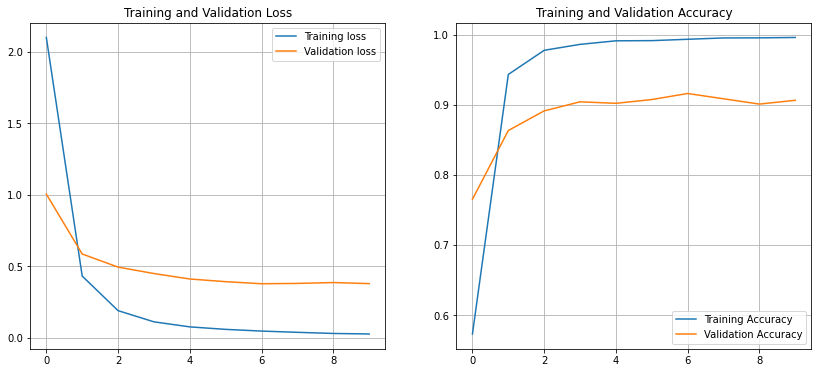

In [189]:
plot_result(history)

In [190]:
tran_model.evaluate(test_ds)

29/29 [==============================] - 9s 321ms/step - loss: 0.3783 - accuracy: 0.9133


[0.3783417046070099, 0.9133333563804626]

#### Now, use the inception_V3 model for transfer learning

In [66]:
icpt_model = tf.keras.applications.InceptionV3(include_top = False,
                                               weights='imagenet'
)

In [67]:
#icpt_model.summary()

In [68]:
icpt_model_num = len(icpt_model.layers)
icpt_model.trainable = True
training_depth = int(0.92 * icpt_model_num)
print("Number of layers in the base model: ", icpt_model_num)
print("Number of untrainable layers:       ", training_depth)
print("Number of layers used for training: ", icpt_model_num - training_depth)

for layer in icpt_model.layers[:training_depth]:
    layer.trainable = False

Number of layers in the base model:  311
Number of untrainable layers:        286
Number of layers used for training:  25


In [69]:
inputs = tf.keras.layers.Input((image_width, image_height, 3))
x = tf.cast(inputs, tf.float32)
x = data_augmentation(x)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = icpt_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(class_num)(x)
icpt_model = tf.keras.Model(inputs, outputs)

In [70]:
initial_lr = 0.0004
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=2000,
    decay_rate=0.5,
    staircase=True)

In [72]:
icpt_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

icpt_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_6 (Tenso [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_6 (TensorFlo [(None, 128, 128, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)             

In [73]:
epochs = 10

history_icpt = icpt_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
229/229 [==============================] - 161s 702ms/step - loss: 1.6766 - accuracy: 0.6155 - val_loss: 0.7228 - val_accuracy: 0.8265
Epoch 2/10
229/229 [==============================] - 163s 712ms/step - loss: 0.7930 - accuracy: 0.7913 - val_loss: 0.5890 - val_accuracy: 0.8427
Epoch 3/10
229/229 [==============================] - 162s 709ms/step - loss: 0.5853 - accuracy: 0.8413 - val_loss: 0.5439 - val_accuracy: 0.8610
Epoch 4/10
229/229 [==============================] - 161s 705ms/step - loss: 0.4632 - accuracy: 0.8704 - val_loss: 0.4810 - val_accuracy: 0.8782
Epoch 5/10
229/229 [==============================] - 161s 704ms/step - loss: 0.3849 - accuracy: 0.8957 - val_loss: 0.5041 - val_accuracy: 0.8621
Epoch 6/10
229/229 [==============================] - 162s 710ms/step - loss: 0.3257 - accuracy: 0.9065 - val_loss: 0.4529 - val_accuracy: 0.8815
Epoch 7/10
229/229 [==============================] - 268s 1s/step - loss: 0.2980 - accuracy: 0.9163 - val_loss: 0.4517 - va

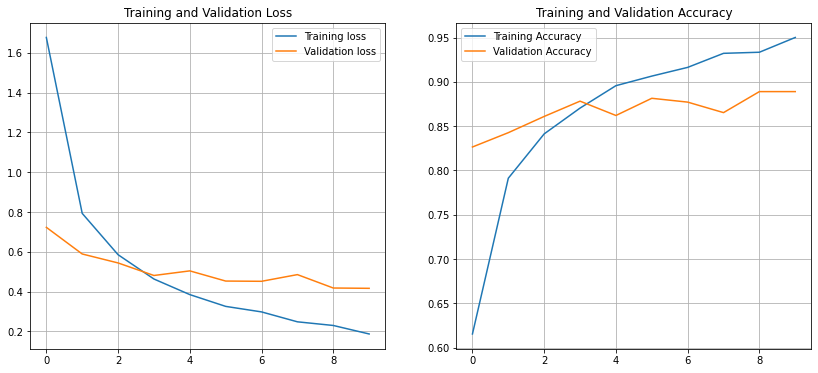

In [74]:
plot_result(history_icpt)

In [75]:
icpt_model.evaluate(test_ds)

29/29 [==============================] - 14s 469ms/step - loss: 0.4917 - accuracy: 0.8644


[0.49170222878456116, 0.8644444346427917]

In [76]:
pred_model = tf.keras.models.Sequential([
    icpt_model,
    tf.keras.layers.Softmax()
])

In [78]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = pred_model.predict_on_batch(image_batch)
for i, p in enumerate(predictions):
    print('Predicted Class: {:20s}({:.2f}%) | Actual Class: {:17s} | {}'.format(
        class_names[np.argmax(p)], 100 * np.max(p), class_names[label_batch[i]],
        class_names[np.argmax(p)] == class_names[label_batch[i]]))

Predicted Class: Faces_easy          (99.98%) | Actual Class: Faces_easy        | True
Predicted Class: schooner            (98.52%) | Actual Class: schooner          | True
Predicted Class: ketch               (70.01%) | Actual Class: ketch             | True
Predicted Class: helicopter          (80.29%) | Actual Class: helicopter        | True
Predicted Class: Faces_easy          (98.58%) | Actual Class: Faces_easy        | True
Predicted Class: buddha              (100.00%) | Actual Class: buddha            | True
Predicted Class: ewer                (99.86%) | Actual Class: ewer              | True
Predicted Class: BACKGROUND_Google   (26.85%) | Actual Class: scorpion          | False
Predicted Class: Motorbikes          (99.95%) | Actual Class: Motorbikes        | True
Predicted Class: Motorbikes          (99.87%) | Actual Class: Motorbikes        | True
Predicted Class: pizza               (67.84%) | Actual Class: pizza             | True
Predicted Class: chandelier          (42.